In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

import time
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import curbside
import utils
import envs

### preparation

In [3]:
net_xml = "seattle.net.xml"
add_xml = "seattle.add.xml"
rou_xml = "seattle.trips.xml"

### no-action

In [4]:
class Policy:
    def __init__(self, curb_ids, policy_name='no-action'):
        self.curb_ids = curb_ids
        self.policy_name = policy_name
        if policy_name == 'nn':
            self.agents = {}
            for curb_id in self.curb_ids:
                self.agents[curb_id] = linear_agent()
            
    def forward(self, states):
        actions = []
        for state, curb_id in zip(states, self.curb_ids):
            # no action
            if self.policy_name == 'no-action':
                action = 0
            # last step experience
            if self.policy_name == 'last_min':
                action = self.last_min_policy(state)
            
            if self.policy_name == 'nn':
                action = self.nn_policy(state, curb_id)
            
            actions.append(action)
        return actions
    
    def last_min_policy(self, state):
        if state[0,0] > state[1,0]:
            action = 1 # delivery vehicle space +1
        elif state[0,0] < state[1,0]:
            action = -1 # delivery vehicle space -1
        else:
            action = 0
        return action
    
    def nn_policy(self, state, curb_id):
        agent = self.agents[curb_id]
        action = agent.forward(torch.tensor(state, dtype=torch.float))
        
        return action

In [5]:
# utils.generate_route(psg_park_dm_x=2, dlv_park_dm_x=3, flow_num=200, simulate_hour=12, seed=2)
env = envs.SeattleEnv(net_xml, add_xml, rou_xml, dlv_prc=5, psg_prc=1, gui=False)
policy = Policy(env.curb_ids, policy_name='no-action')

no_action_res = {}
no_action_res['rewards'] = []
no_action_res['total_reroute'] = []
no_action_res['total_failed'] = []

state = env.reset()

for epoch in range(1):
    while True:
        actions = policy.forward(state)
        done, next_state, reward, global_reward = env.batch(actions, 3600)
        no_action_res['rewards'].append(global_reward)
        no_action_res['total_reroute'].append(env.reroute_total)
        no_action_res['total_failed'].append(env.failed_total)

        state = next_state

        if done:
            env.terminate()
            time.sleep(2)
            env.sim = env._init_sim(env.gui)
            state = env.reset()
            break
    
    print('Epoch = {}, global reward = {}'.format(epoch, global_reward))

env.terminate()

 Retrying in 1 seconds
 Retrying in 1 seconds
Epoch = 0, global reward = 1


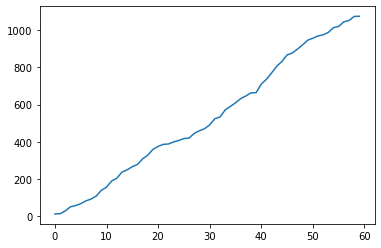

In [6]:
plt.plot(np.cumsum(no_action_res['rewards']))
plt.show()

### last-min experience

In [7]:
# utils.generate_route(psg_park_dm_x=2, dlv_park_dm_x=3, flow_num=200, simulate_hour=12, seed=2)
env = envs.SeattleEnv(net_xml, add_xml, rou_xml, dlv_prc=5, psg_prc=1, gui=False)
policy = Policy(env.curb_ids, policy_name='last_min')

last_min_res = {}
last_min_res['rewards'] = []
last_min_res['total_reroute'] = []
last_min_res['total_failed'] = []

state = env.reset()

for epoch in range(1):
    while True:
        actions = policy.forward(state)
        done, next_state, reward, global_reward = env.batch(actions, 3600)
        last_min_res['rewards'].append(global_reward)
        last_min_res['total_reroute'].append(env.reroute_total)
        last_min_res['total_failed'].append(env.failed_total)

        state = next_state

        if done:
            env.terminate()
            time.sleep(2)
            env.sim = env._init_sim(env.gui)
            state = env.reset()
            break
    
    print('Epoch = {}, global reward = {}'.format(epoch, global_reward))

env.terminate()

 Retrying in 1 seconds
 Retrying in 1 seconds
Epoch = 0, global reward = 2


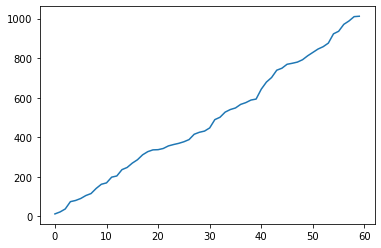

In [8]:
plt.plot(np.cumsum(last_min_res['rewards']))
plt.show()

### Independent

In [9]:
class simple_nn(nn.Module):
    def __init__(self, hidden_state=12):
        super(simple_nn, self).__init__()
        self.start_matrix = torch.empty(12, 4, requires_grad=True)
        nn.init.kaiming_normal_(self.start_matrix)
        
        self.fc1 = nn.Linear(12, hidden_state)
        self.fc2 = nn.Linear(hidden_state, 3)
    
    def forward(self, state):
        action_space = [-1, 0, 1]
        out = state * self.start_matrix
        out = F.relu(torch.sum(out, dim=1))
        out = F.relu(self.fc2(out))
        out = torch.argmax(F.softmax(out, dim=-1), dim=0).detach().numpy()
        action = action_space[out]
        return action


class linear_agent:
    def __init__(self):
        self.nn = simple_nn(hidden_state=12)
        self.optimizer = optim.RMSprop(self.nn.parameters(), lr=0.001)
        
    def forward(self, state):
        return self.nn(state)
    
    def optimize(self, reward):
        self.optimizer.zero_grad()
        loss = torch.tensor(reward, dtype=torch.float, requires_grad=True)
        loss.backward()
        self.optimizer.step()

In [10]:
class Policy:
    def __init__(self, curb_ids, policy_name='no-action'):
        self.curb_ids = curb_ids
        self.policy_name = policy_name
        if policy_name == 'nn':
            self.agents = {}
            for curb_id in self.curb_ids:
                self.agents[curb_id] = linear_agent()
            
    def forward(self, states):
        actions = []
        for state, curb_id in zip(states, self.curb_ids):
            # no action
            if self.policy_name == 'no-action':
                action = 0
            # last step experience
            if self.policy_name == 'last_min':
                action = self.last_min_policy(state)
            
            if self.policy_name == 'nn':
                action = self.nn_policy(state, curb_id)
            
            actions.append(action)
        return actions
    
    def last_min_policy(self, state):
        if state[0,0] > state[1,0]:
            action = 1 # delivery vehicle space +1
        elif state[0,0] < state[1,0]:
            action = -1 # delivery vehicle space -1
        else:
            action = 0
        return action
    
    def nn_policy(self, state, curb_id):
        agent = self.agents[curb_id]
        action = agent.forward(torch.tensor(state, dtype=torch.float))
        
        return action

In [11]:
# utils.generate_route(psg_park_dm_x=2, dlv_park_dm_x=3, flow_num=200, simulate_hour=12, seed=2)
env = envs.SeattleEnv(net_xml, add_xml, rou_xml, dlv_prc=5, psg_prc=1, gui=False)
policy = Policy(env.curb_ids, policy_name='nn')

independent_res = {}
independent_res['rewards'] = []
independent_res['total_reroute'] = []
independent_res['total_failed'] = []

state = env.reset()

for epoch in range(10):
    while True:
        actions = policy.forward(state)
        done, next_state, reward, global_reward = env.batch(actions, 3600)
        independent_res['rewards'].append(global_reward)
        independent_res['total_reroute'].append(env.reroute_total)
        independent_res['total_failed'].append(env.failed_total)

        state = next_state

        for i in range(len(policy.curb_ids)):
            agent = policy.agents[policy.curb_ids[i]]
            agent.optimize(reward[policy.curb_ids[i]])

        if done:
            env.terminate()
            time.sleep(2)
            env.sim = env._init_sim(env.gui)
            state = env.reset()
            break
    
    print('Epoch = {}, global reward = {}'.format(epoch, np.cumsum(independent_res['rewards'])[60*epoch+59] - np.cumsum(independent_res['rewards'])[60*epoch]))

env.terminate()

 Retrying in 1 seconds
 Retrying in 1 seconds
Epoch = 0, global reward = 1006
 Retrying in 1 seconds
Epoch = 1, global reward = 252
 Retrying in 1 seconds
Epoch = 2, global reward = 427
 Retrying in 1 seconds
Epoch = 3, global reward = 627
 Retrying in 1 seconds
Epoch = 4, global reward = 632
 Retrying in 1 seconds
Epoch = 5, global reward = 636
 Retrying in 1 seconds
Epoch = 6, global reward = 618
 Retrying in 1 seconds
Epoch = 7, global reward = 493
 Retrying in 1 seconds
Epoch = 8, global reward = 508
 Retrying in 1 seconds
Epoch = 9, global reward = 606


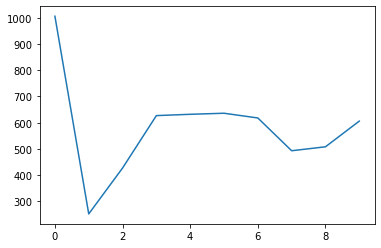

In [13]:
data = np.cumsum(independent_res['rewards'])
plt.plot([data[60*i+59] - data[60*i] for i in range(10)])
plt.show()

### sharing parameters

In [4]:
class simple_nn(nn.Module):
    def __init__(self, hidden_state=12):
        super(simple_nn, self).__init__()
        self.start_matrix = torch.empty(12, 4, requires_grad=True)
        nn.init.kaiming_normal_(self.start_matrix)
        
        self.fc1 = nn.Linear(12, hidden_state)
        self.fc2 = nn.Linear(hidden_state, 3)
    
    def forward(self, state):
        action_space = [-1, 0, 1]
        out = state * self.start_matrix
        out = F.relu(torch.sum(out, dim=1))
        out = F.relu(self.fc2(out))
        out = torch.argmax(F.softmax(out, dim=-1), dim=0).detach().numpy()
        action = action_space[out]
        return action


class linear_agent:
    def __init__(self):
        self.nn = simple_nn(hidden_state=12)
        self.optimizer = optim.RMSprop(self.nn.parameters(), lr=0.0001)
        
    def forward(self, state):
        return self.nn(state)
    
    def optimize(self, reward):
        self.optimizer.zero_grad()
        loss = torch.tensor(reward, dtype=torch.float, requires_grad=True)
        loss.backward()
        self.optimizer.step()

In [5]:
class Policy:
    def __init__(self, curb_ids, policy_name='no-action'):
        self.curb_ids = curb_ids
        self.policy_name = policy_name
        if policy_name == 'nn':
            # only one agent
            self.agent = linear_agent()
            
    def forward(self, states):
        actions = []
        for state, curb_id in zip(states, self.curb_ids):
            # no action
            if self.policy_name == 'no-action':
                action = 0
            # last step experience
            if self.policy_name == 'last_min':
                action = self.last_min_policy(state)
            
            if self.policy_name == 'nn':
                action = self.nn_policy(state, curb_id)
            
            actions.append(action)
        return actions
    
    def last_min_policy(self, state):
        if state[0,0] > state[1,0]:
            action = 1 # delivery vehicle space +1
        elif state[0,0] < state[1,0]:
            action = -1 # delivery vehicle space -1
        else:
            action = 0
        return action
    
    def nn_policy(self, state, curb_id):
        # only one agent
        agent = self.agent
        action = agent.forward(torch.tensor(state, dtype=torch.float))
        
        return action

In [8]:
# utils.generate_route(psg_park_dm_x=2, dlv_park_dm_x=3, flow_num=200, simulate_hour=12, seed=2)
env = envs.SeattleEnv(net_xml, add_xml, rou_xml, dlv_prc=5, psg_prc=1, gui=False)
state = env._get_state()

policy = Policy(env.curb_ids, policy_name='nn')

sharing_res = {}
sharing_res['rewards'] = []
sharing_res['total_reroute'] = []
sharing_res['total_failed'] = []

for epoch in range(10):
    while True:
        actions = policy.forward(state)
        next_state, reward, global_reward = env.batch(actions)
        sharing_res['rewards'].append(global_reward)
        sharing_res['total_reroute'].append(env.reroute_total)
        sharing_res['total_failed'].append(env.failed_total)

        state = next_state

        for i in range(len(policy.curb_ids)):
            policy.agent.optimize(reward[policy.curb_ids[i]])

        if env.time_step >= 3600:
            env.terminate()
            time.sleep(2)
            env = envs.SeattleEnv(net_xml, add_xml, rou_xml, dlv_prc=5, psg_prc=1, gui=False)
            state = env._get_state()
            # env.sim = env._init_sim(env.gui)
            # state = env.reset()
            break
    
    print('Epoch = {}, global reward = {}'.format(epoch, np.cumsum(sharing_res['rewards'])[60*epoch+59] - np.cumsum(sharing_res['rewards'])[60*epoch]))

env.terminate()

 Retrying in 1 seconds
 Retrying in 1 seconds
Epoch = 0, global reward = 2495
 Retrying in 1 seconds
Epoch = 1, global reward = 1390
 Retrying in 1 seconds
Epoch = 2, global reward = 2484
 Retrying in 1 seconds
Epoch = 3, global reward = 2519
 Retrying in 1 seconds
Epoch = 4, global reward = 2422
 Retrying in 1 seconds
Epoch = 5, global reward = 2448
 Retrying in 1 seconds
Epoch = 6, global reward = 2463
 Retrying in 1 seconds
Epoch = 7, global reward = 2493
 Retrying in 1 seconds
Epoch = 8, global reward = 2503
 Retrying in 1 seconds
Epoch = 9, global reward = 2491


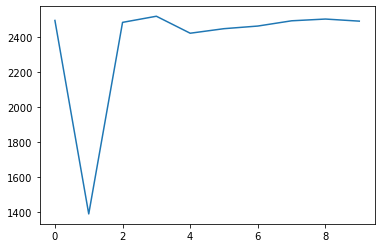

In [9]:
data = np.cumsum(sharing_res['rewards'])

plt.plot([data[60*i+59] - data[60*i] for i in range(10)])
plt.show()

## Hyperparameter

### demand combinations

In [24]:
psg_park_dm_x_list = [1, 1.5, 2]
dlv_park_dm_x_list = [1, 1.5, 2, 2.5, 3]
demand_combine = list(product(psg_park_dm_x_list, dlv_park_dm_x_list))
print(demand_combine)

[(1, 1), (1, 1.5), (1, 2), (1, 2.5), (1, 3), (1.5, 1), (1.5, 1.5), (1.5, 2), (1.5, 2.5), (1.5, 3), (2, 1), (2, 1.5), (2, 2), (2, 2.5), (2, 3)]


In [ ]:
totol_reroutes = []
total_failed_parkings = []

for (psg_park_dm_x, dlv_park_dm_x) in demand_combine:
    utils.generate_route(psg_park_dm_x=psg_park_dm_x, dlv_park_dm_x=dlv_park_dm_x, flow_num=200, simulate_hour=12, seed=2)
    env = envs.SeattleEnv(net_xml, add_xml, rou_xml, gui=False)
    # policy = Policy(env.curb_ids, policy_name='no-action')
    policy = Policy(env.curb_ids, policy_name='no-action')
    
    total_reroute = []
    total_failed_parking = []
    
    while True:
        actions = policy.forward(env.reroute_vtype)
        done = env.batch(actions, 3600)
        total_reroute.append(env.reroute_total)
        total_failed_parking.append(env.failed_parking)
        if done:
            break
            
    totol_reroutes.append(total_reroute)
    total_failed_parkings.append(total_failed_parking)
    
    print('psg:', psg_park_dm_x, 'dlv:', dlv_park_dm_x)
#     print('totol_reroutes:', totol_reroutes)
#     print('total_failed_parkings:', total_failed_parkings)
    
    env.terminate()

psg: 1 dlv: 1
psg: 1 dlv: 1.5
psg: 1 dlv: 2
psg_310 enter 3282
psg_310 enter 3301
psg_310 enter 3310
psg: 1 dlv: 2.5


In [7]:
env.terminate()

KeyError: 'sim1'

In [8]:
reroutes = np.array(totol_reroutes)

In [16]:
failed_parkings = np.array(total_failed_parkings)

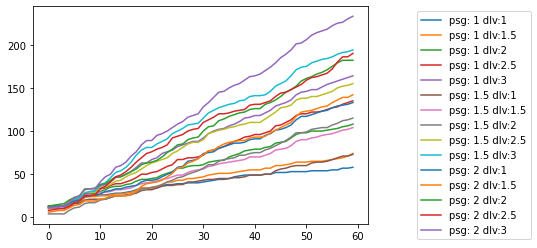

In [30]:
import matplotlib.pyplot as plt
for i in range(len(demand_combine)):
    psg, dlv = demand_combine[i]
    plt.plot(reroutes[i], label = 'psg: ' + str(psg) + ' dlv:' + str(dlv))
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

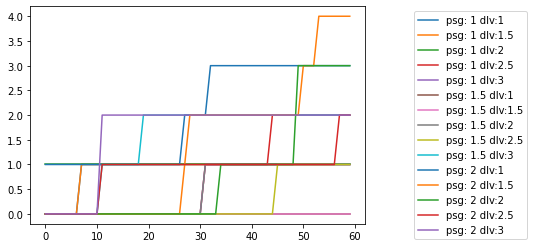

In [29]:
for i in range(len(demand_combine)):
    psg, dlv = demand_combine[i]
    plt.plot(failed_parkings[i], label = 'psg: ' + str(psg) + ' dlv:' + str(dlv))
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

## psg dlv combinations

In [32]:
def Test_Demand_Reroute(demand_combine):
    totol_reroutes = []
    total_failed_parkings = []
    for (psg_park_dm_x, dlv_park_dm_x) in demand_combine:
        utils.generate_route(psg_park_dm_x=psg_park_dm_x, dlv_park_dm_x=dlv_park_dm_x, flow_num=200, simulate_hour=12, seed=2)
        env = envs.SeattleEnv(net_xml, add_xml, rou_xml, gui=False)
        # policy = Policy(env.curb_ids, policy_name='no-action')
        policy = Policy(env.curb_ids, policy_name='no-action')

        total_reroute = []
        total_failed_parking = []

        while True:
            actions = policy.forward(env.reroute_vtype)
            done = env.batch(actions, 3600)
            total_reroute.append(env.reroute_total)
            total_failed_parking.append(env.failed_parking)
            if done:
                break

        totol_reroutes.append(total_reroute)
        total_failed_parkings.append(total_failed_parking)

        print('psg:', psg_park_dm_x, 'dlv:', dlv_park_dm_x)

        env.terminate()
    return np.array(totol_reroutes), np.array(total_failed_parkings)

In [34]:
psg_park_dm_x_list = [1, 2, 3, 4, 5]
dlv_park_dm_x_list = [1, 2, 3, 4, 5]
demand_combine = list(product(psg_park_dm_x_list, dlv_park_dm_x_list))
print(demand_combine)
reroutes_1, failed_parkings_1 = Test_Demand_Reroute(demand_combine)

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
seattle.trips.xml re-generated. (demand factor = 1 )
psg: 1 dlv: 1
seattle.trips.xml re-generated. (demand factor = 1 )
psg: 1 dlv: 2
seattle.trips.xml re-generated. (demand factor = 1 )
psg: 1 dlv: 3
seattle.trips.xml re-generated. (demand factor = 1 )
psg: 1 dlv: 4
seattle.trips.xml re-generated. (demand factor = 1 )
psg: 1 dlv: 5
seattle.trips.xml re-generated. (demand factor = 2 )
psg: 2 dlv: 1
seattle.trips.xml re-generated. (demand factor = 2 )
psg: 2 dlv: 2
seattle.trips.xml re-generated. (demand factor = 2 )
psg: 2 dlv: 3
seattle.trips.xml re-generated. (demand factor = 2 )
psg: 2 dlv: 4
seattle.trips.xml re-generated. (demand factor = 2 )
psg: 2 dlv: 5
seattle.trips.xml re-generated. (demand factor = 3 )
psg: 3 dlv: 1
seattle.trips.xml re-generated. (demand factor = 3 )
psg: 3 dl

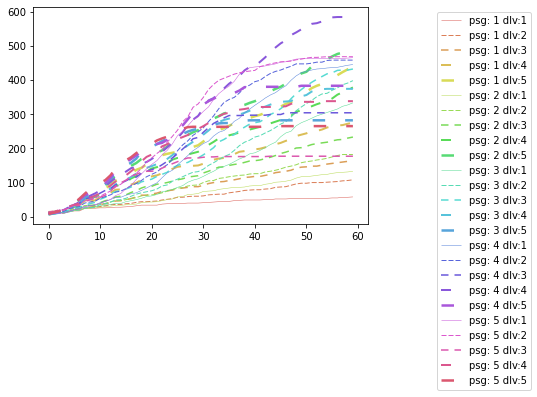

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

NUM_COLORS = len(demand_combine)
# LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

sns.reset_orig()  
clrs = sns.color_palette('hls', n_colors=NUM_COLORS)  # a list of RGB tuples

fig, ax = plt.subplots(1)
for i in range(len(demand_combine)):
    psg, dlv = demand_combine[i]
    lines = ax.plot(reroutes_1[i], label = 'psg: '+str(psg)+' dlv:'+str(dlv), linestyle='dashed', dashes=(5, i%5*2), linewidth=(i%5+1)/2)
    lines[0].set_color(clrs[i])
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
#     lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
plt.show()

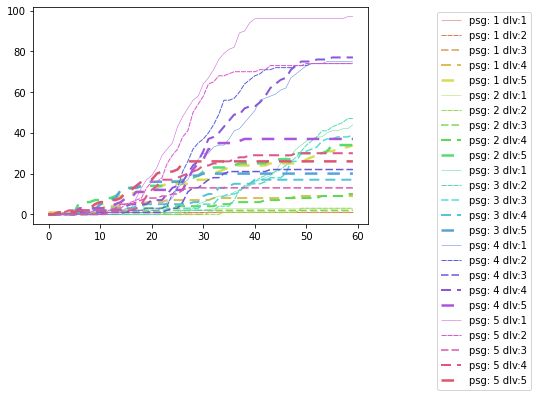

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

NUM_COLORS = len(demand_combine)
# LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
NUM_STYLES = len(LINE_STYLES)

sns.reset_orig()  
clrs = sns.color_palette('hls', n_colors=NUM_COLORS)  # a list of RGB tuples


fig, ax = plt.subplots(1)
for i in range(len(demand_combine)):
    psg, dlv = demand_combine[i]
    lines = ax.plot(failed_parkings_1[i], label = 'psg: '+str(psg)+' dlv:'+str(dlv), linestyle='dashed', dashes=(5, i%5), linewidth=(i%5+1)/2)
    lines[0].set_color(clrs[i])
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
#     lines[0].set_linestyle(LINE_STYLES[i%NUM_STYLES])
plt.show()

In [64]:
np.reshape(reroutes_1[:,-1], (5,5))

array([[ 58, 108, 164, 275, 437],
       [133, 182, 233, 378, 489],
       [333, 398, 432, 374, 282],
       [445, 458, 304, 585, 383],
       [465, 468, 177, 338, 265]])

In [75]:
np.reshape(failed_parkings_1[:,-1], (5,5))

array([[ 1,  1,  1,  9, 34],
       [ 3,  3,  2, 10, 34],
       [44, 47, 39, 17, 20],
       [75, 74, 22, 77, 37],
       [97, 74, 13, 30, 26]])

# psg dlv combinations with different seed

In [5]:
def Test_Demand_Reroute_Seed(demand_combine, num_seeds = 5):
    totol_reroutes_seeds = {}
    total_failed_parkings_seeds = {}
    total_failed_parkings_psg_seeds = {}
    total_failed_parkings_dlv_seeds = {}
    for i in range(num_seeds):
        seed = i
        totol_reroutes = []
        total_failed_parkings = []
        total_failed_parkings_psg = []
        total_failed_parkings_dlv = []
        for (psg_park_dm_x, dlv_park_dm_x) in demand_combine:
            utils.generate_route(psg_park_dm_x=psg_park_dm_x, dlv_park_dm_x=dlv_park_dm_x, flow_num=200, simulate_hour=12, seed=seed)
            env = envs.SeattleEnv(net_xml, add_xml, rou_xml, gui=False)
            # policy = Policy(env.curb_ids, policy_name='no-action')
            policy = Policy(env.curb_ids, policy_name='no-action')

            total_reroute = []
            total_failed_parking = []
            total_failed_parking_psg = []
            total_failed_parking_dlv = []

            while True:
                actions = policy.forward(env.reroute_vtype)
                done = env.batch(actions, 3600)
                total_reroute.append(env.reroute_total)
                total_failed_parking.append(env.failed_parking)
                total_failed_parking_psg.append(env.failed_parking_psg)
                total_failed_parking_dlv.append(env.failed_parking_dlv)
                if done:
                    break

            totol_reroutes.append(total_reroute)
            total_failed_parkings.append(total_failed_parking)
            total_failed_parkings_psg.append(total_failed_parking_psg)
            total_failed_parkings_dlv.append(total_failed_parking_dlv)

            print('seed:', seed, 'psg:', psg_park_dm_x, 'dlv:', dlv_park_dm_x, 'rer:', total_reroute[-1], 'fp:', total_failed_parking[-1], \
                  'fp_psg:', total_failed_parking_psg[-1], 'fp_dlv:', total_failed_parking_dlv[-1])

            env.terminate()
        totol_reroutes_seeds[seed] = totol_reroutes
        total_failed_parkings_seeds[seed] = total_failed_parkings
        total_failed_parkings_psg_seeds[seed] = total_failed_parkings_psg
        total_failed_parkings_dlv_seeds[seed] = total_failed_parkings_dlv_seeds
    return totol_reroutes_seeds, total_failed_parkings_seeds, total_failed_parkings_psg_seeds, total_failed_parkings_dlv_seeds

In [6]:
# psg_park_dm_x_list = [2]
# dlv_park_dm_x_list = [4]
# demand_combine = list(product(psg_park_dm_x_list, dlv_park_dm_x_list))
# print(demand_combine)
# reroutes, fail_park, fail_park_psg, fail_park_dlv = Test_Demand_Reroute_Seed(demand_combine, num_seeds=2)

In [7]:
psg_park_dm_x_list = [1, 1.5, 2]
dlv_park_dm_x_list = [1, 1.5, 2, 2.5, 3, 3.5, 4]
demand_combine = list(product(psg_park_dm_x_list, dlv_park_dm_x_list))
print(demand_combine)
reroutes, fail_park, fail_park_psg, fail_park_dlv = Test_Demand_Reroute_Seed(demand_combine, num_seeds=10)

[(1, 1), (1, 1.5), (1, 2), (1, 2.5), (1, 3), (1, 3.5), (1, 4), (1.5, 1), (1.5, 1.5), (1.5, 2), (1.5, 2.5), (1.5, 3), (1.5, 3.5), (1.5, 4), (2, 1), (2, 1.5), (2, 2), (2, 2.5), (2, 3), (2, 3.5), (2, 4)]
seed: 0 psg: 1 dlv: 1 rer: 50 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1 dlv: 1.5 rer: 70 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1 dlv: 2 rer: 75 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1 dlv: 2.5 rer: 114 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1 dlv: 3 rer: 149 fp: 1 fp_psg: 0 fp_dlv: 1
seed: 0 psg: 1 dlv: 3.5 rer: 176 fp: 2 fp_psg: 0 fp_dlv: 2
seed: 0 psg: 1 dlv: 4 rer: 261 fp: 6 fp_psg: 0 fp_dlv: 6
seed: 0 psg: 1.5 dlv: 1 rer: 74 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1.5 dlv: 1.5 rer: 75 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1.5 dlv: 2 rer: 113 fp: 2 fp_psg: 1 fp_dlv: 1
seed: 0 psg: 1.5 dlv: 2.5 rer: 129 fp: 0 fp_psg: 0 fp_dlv: 0
seed: 0 psg: 1.5 dlv: 3 rer: 165 fp: 1 fp_psg: 0 fp_dlv: 1
seed: 0 psg: 1.5 dlv: 3.5 rer: 222 fp: 2 fp_psg: 0 fp_dlv: 2
seed: 0 psg: 1.5 dlv: 4 rer: 279 fp: 10

In [32]:
sum_reroutes = np.zeros_like(reroutes[0])
max_reroutes = np.zeros_like(reroutes[0])
min_reroutes = np.full(np.shape(reroutes[0]), 1000)

# print(sum_reroutes)
for k, v in reroutes.items():
#     print(np.array(v))
    sum_reroutes += np.array(v)
    max_reroutes = np.maximum(max_reroutes, np.array(v))
    min_reroutes = np.minimum(min_reroutes, np.array(v))
mean_reroutes = sum_reroutes / len(reroutes)


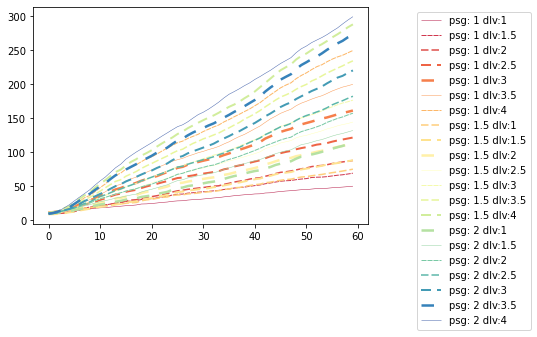

In [47]:
NUM_COLORS = len(demand_combine)

sns.reset_orig()  
clrs = sns.color_palette('Spectral', n_colors=NUM_COLORS)  # a list of RGB tuples

fig, ax = plt.subplots(1)
for i in range(len(demand_combine)):
    psg, dlv = demand_combine[i]
    lines = ax.plot(mean_reroutes[i], label = 'psg: '+str(psg)+' dlv:'+str(dlv), linestyle='dashed', dashes=(5, i%5), linewidth=(i%5+1)/2)
    lines[0].set_color(clrs[i])
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

In [39]:
np.shape(mean_reroutes)

(21, 60)

In [40]:
mean_reroutes

array([[ 11.4,  11.6,  11.7, ...,  48.8,  49.4,  50.1],
       [ 11.5,  12.2,  12.6, ...,  66.9,  68. ,  69.2],
       [  9.5,   9.8,  10.1, ...,  85.8,  86.8,  87.9],
       ...,
       [  9.6,  10.6,  11.8, ..., 212.3, 216.6, 220.3],
       [  9.4,  10.8,  13.2, ..., 263.8, 268.9, 272.5],
       [  9.6,  11.5,  13.8, ..., 288.6, 294.2, 299.3]])

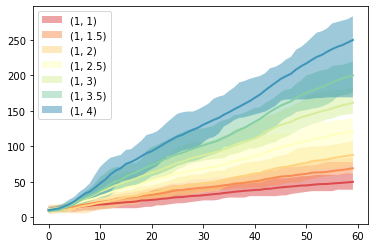

In [80]:

lines = [0,1,2,3,4,5,6]
clrs = sns.color_palette('Spectral', n_colors=len(lines))  # a list of RGB tuples
fig, ax = plt.subplots(1)
t = np.arange(len(mean_reroutes[0]))
for i in lines:
    ax.plot(t, mean_reroutes[i], lw=2, color=clrs[i])
    # ax.plot(mean_reroutes, lw=1, label='population mean', color='black', ls='--')
    ax.fill_between(t, min_reroutes[i], max_reroutes[i], facecolor=clrs[i], alpha=0.5,
                    label=demand_combine[i])
    ax.legend(loc='upper left')


In [52]:
min_reroutes[13]

array([ 10.8,  12.1,  13.8,  17.7,  20.2,  25.8,  31.4,  36.8,  41. ,
        48. ,  53.8,  59. ,  65.1,  70.9,  74.5,  80.7,  85.9,  89.8,
        95.1,  98.8, 103. , 108.3, 113.1, 117.5, 121.7, 126.8, 130.5,
       135.4, 139.4, 143.4, 147.2, 150.8, 154.1, 158.1, 162.6, 166.8,
       170.2, 174.4, 179.5, 184. , 189.4, 195.7, 201.9, 208.2, 214.6,
       220.7, 225. , 229.2, 236.4, 241.6, 245.2, 250.3, 255. , 258.9,
       263.6, 268.9, 273.4, 278.3, 283.6, 288. ])

In [51]:
max_reroutes[13]

array([ 15,  19,  24,  32,  35,  37,  40,  50,  58,  77,  85,  98, 105,
       109, 112, 117, 118, 119, 121, 123, 129, 134, 141, 147, 151, 154,
       158, 162, 167, 170, 174, 182, 190, 196, 198, 201, 203, 208, 211,
       213, 215, 224, 231, 241, 245, 247, 250, 259, 272, 276, 282, 289,
       296, 299, 307, 312, 318, 323, 330, 334])

In [34]:
min_reroutes[13]

array([[  8,   8,   8, ...,  39,  39,  39],
       [ 10,  10,  10, ...,  60,  61,  62],
       [  5,   5,   6, ...,  71,  72,  72],
       ...,
       [  7,   9,  10, ..., 186, 192, 194],
       [  6,   6,   6, ..., 222, 225, 226],
       [  6,   6,   9, ..., 132, 132, 132]])